# Milestone 2: Project proposal and initial analyses

We chose the **[CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)**. This dataset contains 42,306 movie plot summaries extracted from Wikipedia + aligned metadata extracted from Freebase.

Using this dataset, we want to dive into the **drivers of an actor's success**, following several definitions.

In [422]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import ast 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

## 1. Exploration of the dataset

### Movies metadata

In [423]:
movies = pd.read_table('~/ADA2023/Project/Data/MovieSummaries/movie.metadata.tsv', header=None)
movies.columns = ['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date','Movie box office revenue','Movie runtime','Movie languages','Movie countries','Movie genres']

In [424]:
# Remove leading and trailing spaces, then parse the dictionaries
movies['Movie languages'] = movies['Movie languages'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie countries'] = movies['Movie countries'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})
movies['Movie genres'] = movies['Movie genres'].apply(lambda x: ast.literal_eval(x.strip()) if x.strip() else {})

### Characters metadata

In [425]:
characters = pd.read_table('~/ADA2023/Project/Data/MovieSummaries/character.metadata.tsv', header=None)
characters.columns = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character name','Actor date of birth','Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release','Freebase character/actor map ID','Freebase character ID','Freebase actor ID']

## 2. Complementary datasets

The success can be characterized based on several factors, 
- Longevity: for how long has the actor been in the film industry? 
- In how many films the actor has participated?
- IMDB ratings:
- The Oscars
- Google search results
- Film revenue
- Number of film spectators

Some of these indicators require additional datasets. We thus complement our analysis with data on awards, on ratings, and on popularity.

## 2.1 [Oscars' winners and nominees](https://datahub.io/rufuspollock/oscars-nominees-and-winners)

### The dataset

In [426]:
oscars = pd.read_csv('~/ADA2023/Project/Data/oscar_awards.csv')

In [427]:
oscars.columns

Index(['year', 'category', 'winner', 'entity'], dtype='object')

**Oscar nominations and awards by gender**

In [522]:
oscars_actors = oscars[(oscars['category'].str.contains("ACTOR")) | (oscars['category'].str.contains("ACTRESS"))]

In [519]:
# Group by gender and year and calculate the number of total observations and winners
mask = oscars_actors['category'].str.contains("ACTOR")

oscars_actors.loc[:, 'gender'] = 'Female'
oscars_actors.loc[mask, 'gender'] = 'Male'

oscars_per_year_gender = oscars_actors.groupby(['year', 'gender'])['winner'].agg(['count', 'sum']).reset_index()
oscars_per_year_gender = oscars_per_year_gender.rename(columns={'count': 'Nominees', 'sum': 'Winners'})

In [520]:
oscars_per_year_gender

,year,gender,Nominees,Winners
0,1927,Female,3,1
1,1927,Male,2,1
2,1928,Female,6,1
3,1928,Male,5,1
4,1929,Female,6,1
...,...,...,...,...
175,2015,Male,10,2
176,2016,Female,10,2
177,2016,Male,10,2
178,2017,Female,10,2


Until 1975, there was only one category for actors and one for actresses. Nowadays, there are leading and supporting categories for each gender. We choose to consider both categories as Oscar winner indistinctively.

**Merge with CMU Movie Corpus**

In [431]:
characters_oscars = characters.merge(oscars_actors, left_on='Actor name', right_on='entity', how='left')

print('There are {}% of Oscar nominees or winners in the movies dataset.'.format(round(100 - characters_oscars['entity'].isna().sum()/characters_oscars.shape[0] * 100,2)))

There are 14.31% of Oscar nominees or winners in the movies dataset.


In [526]:
characters_oscars_test = characters.merge(oscars_actors, left_on='Actor name', right_on='entity', how='right')

print('Only {}% of Oscar nominees or winners ({}) do not appear in our movies dataset.'.format(round(characters_oscars_test['Actor name'].isna().sum()/characters_oscars_test.shape[0] * 100,2), characters_oscars_test['Actor name'].isna().sum()))

Only 0.04% of Oscar nominees or winners (28) do not appear in our movies dataset.


In [530]:
characters_oscars_test[characters_oscars_test['Actor name'].isna()][['entity', 'year', 'winner']]

,entity,year,winner
3940,Anne Shirley,1937,False
3976,Dame May Whitty,1937,False
5774,Charles Chaplin,1940,False
6037,Albert Basserman,1940,False
8259,Dame May Whitty,1942,False
18920,Sir Laurence Olivier,1956,False
19830,Vittorio De Sica,1957,False
24975,Dame Edith Evans,1963,False
25816,Dame Edith Evans,1964,False
27123,Anouk Aimee,1966,False


A few Oscar winners and nominees don't appear in our dataset. Movies were extracted from a dump of Freebase in 2012. If actors began their career after this date, they can't appear in the CMU Movies Corpus. For missing values before that, the source of the missing values is unclear, but the number of actors concerned is small enough to be ignored.

In [ ]:
characters_movie_oscars = characters_oscars.merge(movies, on= 'Freebase movie ID')

### Preparing the features and outcome

**Variables of interest**

In [435]:
characters_movie_oscars.columns

Index(['Wikipedia movie ID_x', 'Freebase movie ID', 'Movie release date_x',
       'Character name', 'Actor date of birth', 'Actor gender', 'Actor height',
       'Actor ethnicity', 'Actor name', 'Actor age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID', 'year', 'category', 'winner', 'entity', 'gender',
       'Wikipedia movie ID_y', 'Movie name', 'Movie release date_y',
       'Movie box office revenue', 'Movie runtime', 'Movie languages',
       'Movie countries', 'Movie genres', 'languages', 'countries', 'genres'],
      dtype='object')

Actors are nominated for an Oscar for a specific performance in a single film. The period of eligibility is the full previous calendar year from January 1 to December 31 (Source: [Wikipedia](https://en.wikipedia.org/wiki/Academy_Award_for_Best_Actor#:~:text=The%20first%20winner%20was%20Emil,other%20actors%20have%20won%20twice.)). Hence, it is important to associate a nomination for or an award to a specific movie and year, and to use only features that are associated to it to predict the Oscar outcome. For instance, someone's age on the movie release date might matter, but their birthdate does not. Similarly, the longevity of the actor's career, comprising years after the Oscar is not relevant. 

Hence, we isolate the following variables that might explain the nomination or winning of an Oscar:
- Actor's age on movie release date
- Actor's gender
- Actor's ethnicity
- Actor's height
- Movie language
- Country of the movie
- Genre of the movie
- Movie runtime
- (to add: type of role)

Movie release date could matter relatively to a year, for instance movies released in January might have more time to convince the jury. However, given that we do not consistently have the month present in our data, we ignore this variable.

In [539]:
characters_movie_oscars['Movie release date'] = pd.to_datetime(characters_movie_oscars['Movie release date_x'], format='mixed', errors='coerce')

# How much month data do we have?
characters_movie_oscars['date_content'] = 'Unknown'
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].dt.month.notna(), 'date_content'] = 'Full Date'
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].dt.month.isna(), 'date_content'] = 'Year'
characters_movie_oscars.loc[(characters_movie_oscars['Movie release date'].dt.month == 1) & (characters_movie_oscars['Movie release date'].dt.day == 1) , 'date_content'] = 'Year' # automatically imputed
characters_movie_oscars.loc[characters_movie_oscars['Movie release date'].isnull(), 'date_content'] = 'Missing'

count_occurrences = characters_movie_oscars['date_content'].value_counts()

print(count_occurrences)

date_content
Full Date    315439
Year         162645
Missing       10358
Name: count, dtype: int64


In [434]:
# Changing the dictionnary in the data into values
for variable in list(['languages', 'countries', 'genres']): 

    full_var = 'Movie ' + variable
    characters_movie_oscars[full_var] = characters_movie_oscars[full_var].apply(lambda x: {variable: None} if not x else x)
    characters_movie_oscars[variable] = characters_movie_oscars[full_var].apply(lambda x: list(x.values())[0]) # only keeping the first genre or country

# Remove ' Language' from values in the 'Language' column
characters_movie_oscars['languages'] = characters_movie_oscars['languages'].str.replace(' Language', '')
characters_movie_oscars['languages'] = characters_movie_oscars['languages'].str.replace(' language', '')

In [438]:
# Choose the relevant features
actors_features = ['Movie release date_x', 'Actor gender', 'Actor age at movie release', 'Actor height', 'Actor ethnicity', 'Movie runtime', 'languages', 'countries', 'genres']

X = characters_movie_oscars[actors_features].copy()

# Prepare the features vector for training by converting the value to floats
X_['Actor age at movie release'] = X_['Actor age at movie release'].astype('category')

gender_mapping = {'M': 1, 'F': 2}
X_['Actor gender'] = X_['Actor gender'].map(gender_mapping)

# Fit the encoder to the categorical variables and transform them
label_encoder = LabelEncoder()
X_['Encoded language'] = label_encoder.fit_transform(X_['languages'])
X_['Encoded genre'] = label_encoder.fit_transform(X_['genres'])
X_['Encoded country'] = label_encoder.fit_transform(X_['countries'])
X_['Encoded ethnicity'] = label_encoder.fit_transform(X_['Actor ethnicity'])

In [440]:
X_ = X_.drop(['Movie release date_x', 'Actor ethnicity', 'genres', 'countries', 'languages'], axis=1)

In [439]:
# Store the dictionaries for more interpretability later
language_dict = dict(zip(X_['languages'], X_['Encoded language']))
country_dict = dict(zip(X_['countries'], X_['Encoded country']))
genre_dict = dict(zip(X_['genres'], X_['Encoded genre']))
ethnicity_dict = dict(zip(X_['Actor ethnicity'], X_['Encoded ethnicity']))

print(language_dict)

{'English': 28, 'Malayalam': 67, 'Mandarin Chinese': 68, 'Hindi': 44, 'Italian': 53, 'Japanese': 55, 'Korean': 60, 'French': 34, 'Tamil': 105, 'German': 41, 'Cantonese': 17, 'Tagalog': 103, 'Croatian': 22, 'Greek': 42, 'Spanish': 97, 'Silent film': 91, 'Polish': 80, 'Russian': 86, 'Marathi': 69, 'Hungarian': 47, 'Standard Mandarin': 99, 'Swedish': 102, 'Standard Cantonese': 98, 'Danish': 25, 'Māori': 73, 'Telugu': 106, 'Tibetans': 108, 'Chinese': 20, 'Serbo-Croatian': 89, 'Czech': 24, 'Finnish': 32, 'Arabic': 6, 'Dutch': 27, 'Esperanto': 29, 'Bengali': 13, 'Ukrainian': 112, 'American English': 3, 'Afrikaans': 0, 'Quechua': 83, 'Thai': 107, 'Oriya': 78, 'Irish': 52, 'Vietnamese': 114, 'Romanian': 85, 'Serbian': 88, 'Icelandic': 49, 'Assamese': 9, 'Latin': 63, 'Swahili': 101, 'Hebrew': 43, 'Filipino': 31, 'Taiwanese': 104, 'Urdu': 113, 'Kannada': 56, 'Malay': 66, 'Yiddish': 117, 'Punjabi': 82, 'Indonesian': 50, 'Jamaican Creole English': 54, 'Portuguese': 81, 'Friulian': 37, 'Norwegian':

In [ ]:
# Removing missing values, for now imputations don't make sense here. 
# But because of ethnicity and height we get rid of a lot of observations
X_ = X[~(X.isna().any(axis=1))].copy()
len(X_[X_.isna().any(axis=1)])

In [ ]:
# To revert the encoding
display(X_)

In [437]:
# We only consider someone a nominee/winner on the year direcly following a movie 
characters_movie_oscars['post'] = ((characters_movie_oscars['year'] == characters_movie_oscars['Movie release date'].dt.year + 1)  & (characters_movie_oscars['year'].notnull())).astype(int)

In [445]:
#Prepare the outcome vector for training
characters_movie_oscars['nomination_status'] = characters_movie_oscars['winner'].map({0: 1, 1: 2})
characters_movie_oscars['nomination_status'].fillna(0, inplace=True)

# Store the dictionary
outcome_mapping = {0: 'gets nothing', 1: 'is nominated for an Oscar', 2: 'wins an Oscar'}

y = characters_movie_oscars['nomination_status'].astype('int')*characters_movie_oscars['post'] # winner x post movie

# We remove the same observations as for the features vector
y_ = y[~(X.isna().any(axis=1))]

In [543]:
display(y_)

1         0
2         0
5         0
79        0
80        0
         ..
488360    0
488404    0
488416    0
488417    0
488439    0
Length: 76101, dtype: int64

### Predicting Oscars' nomination status with a Random Forest Classifier

We face a supervised classification problem and we expect non lininearity. Moreover, the features we consider don't have a spatial representation so no notion of distance. For these reason, a tree model is adequate. It is easily interpretable and allows to understand what features matter for getting an Oscar, which is ultimately what we are interested in.

In [544]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     14607
           1       0.11      0.04      0.06       475
           2       0.00      0.00      0.00       139

    accuracy                           0.95     15221
   macro avg       0.36      0.34      0.35     15221
weighted avg       0.93      0.95      0.94     15221



In [449]:
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importances with feature names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

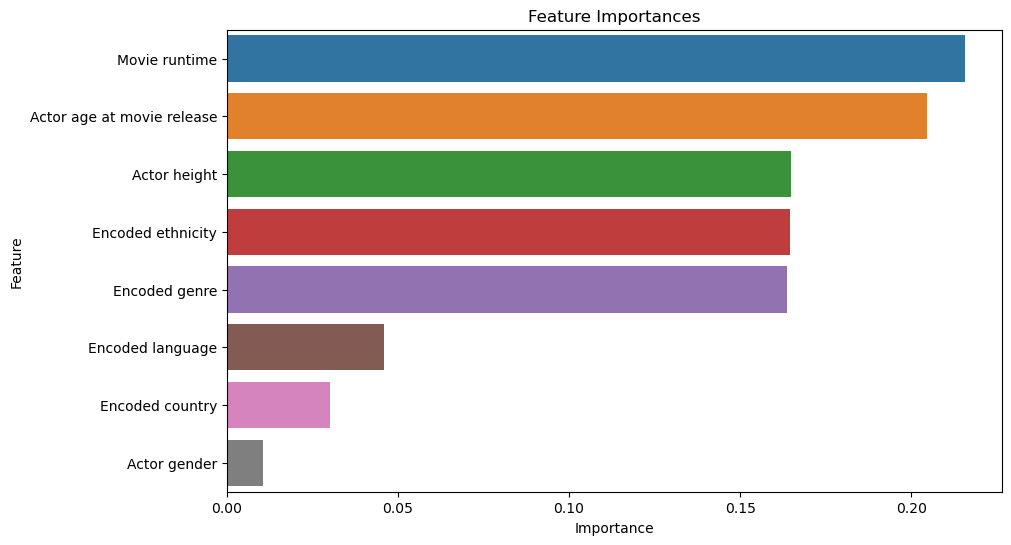

In [547]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

It makes sense that gender does not matter much since both men and women win as many Oscars.

In [205]:
X_.columns

Index(['Actor gender', 'Actor age at movie release', 'Actor height',
       'Movie runtime', 'Encoded language', 'Encoded genre', 'Encoded country',
       'Encoded ethnicity'],
      dtype='object')

In [460]:
def transform_features(input_features):
    """Reverses encoding for prediction"""
    string_indices = [0, 4, 5, 6, 7] # to change if order of variables changes
    
    for index in string_indices:
        if input_features[index] in gender_mapping:
            input_features[index] = gender_mapping[input_features[index]]
        elif input_features[index] in language_dict:
            input_features[index] = language_dict[input_features[index]]
        elif input_features[index] in genre_dict:
            input_features[index] = genre_dict[input_features[index]]
        elif input_features[index] in country_dict:
            input_features[index] = country_dict[input_features[index]]
     #   elif input_features[index] in ethnicity_dict:
      #      input_features[index] = ethnicity_dict[input_features[index]]

    return input_features

[2, 74, 1.6, 110, 28, 217, 71, 126]


In [551]:
# Prediction of oscars based on an input vector of features

input_features = ['M',74,1.6,110,'English', 'Thriller', 'United States of America', 126]
transformed_features = transform_features(input_features)

predicted_label = model.predict([transformed_features])[0] # we need a mapping of ethnicities to interpret it
outcome = outcome_mapping[predicted_label]

print('This actor/actress {}.'.format(outcome))

[2, 74, 1.6, 110, 28, 217, 71, 126]
This actor/actress gets nothing.


/Users/atoure/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Creating a score index

We want to create a score between 0 and 5 based on the probability of being nominated or winning an Oscar for a given movie and actor. 
For instanec, we can assign the score 5 for someone winning and 3 for someone being nominated. Then, we use probabilities to weigh this score and obtain an index between 0 and 5.

In [480]:
proba = model.predict_proba([predicted_label])

/Users/atoure/miniconda3/envs/ada/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [481]:
oscar_score= 5*proba[0][2] + 3*proba[0][1]

In [549]:
print('Given the probabilities {}, the Award score is {}.'.format(proba, round(oscar_score,2)))

Given the probabilities [[0.49357143 0.50642857 0.        ]], the Award score is 1.52.


### Limitations of the dataset

The Oscars take place in the US and are usually political. It is less likely for popular foreign actors to win an award outside the best international film category, even if some film industries are very big outside of Hollywood, such as Bollywood and Nollywood.

We haven't found an exhaustive dataset of awards. We might decide to extend the analysis to more award ceremonies but none is exempt from this national preference: The Australian Film Institute Awards, The BAFTA Film Awards (UK), the Césars Film Awards (France), the Golden Bears (Germany), the Golden Globes (US), the Golden Lions (Venice), the Palme d'Or awards (France), the Sundance Film Festival awards (independent movies), Filmfare (Hindi), etc.

We do not aim at doing an exhaustive analysis, but it is important here to understand that we have a Western bias and we might need to use other indicators to better understand success of actors outside of Hollywood. 

Using our score indices complementarily is key to go past potential biases.

In [561]:
# What are movie nationalities of actors that won an Oscar?
oscar_winers = characters_oscars[characters_oscars['winner'] == True].merge(movies, on='Freebase movie ID', how='left') 

# Flatten the dictionaries and count countries occurrences
countries_counts = Counter(country for countries_dict in oscar_winers["Movie countries"] for country in countries_dict.values())

filtered_countries_counts = {country: count for country, count in countries_counts.items() if count > 500}
sorted_countries_counts = dict(sorted(filtered_countries_counts.items(), key=lambda item: item[1], reverse=True))

sorted_countries_counts # Indian movies are not represented at all despite their big industry

{'United States of America': 12598,
 'United Kingdom': 2393,
 'France': 667,
 'Germany': 530,
 'Italy': 507}

Another issue is that we do not have mapping of ethnicity so we even though we know this feature matters, we cannot really explain how. Additionally, it is largely missing, so it might be better not to include it.

In [558]:
result = characters_movie_oscars.groupby('Actor ethnicity')['Actor name'].agg(['first', 'count']).sort_values(by='count', ascending=False).nlargest(5, 'count')

for ethnicity, values in result.iterrows():
    print(f"For '{ethnicity}':")
    print(f"  - First actor: {values['first']}")
    print(f"  - Total count: {values['count']}")
    print("----")
    
# Indian, white, black? Seems more precise than this

For '/m/0dryh9k':
  - First actor: Mohanlal
  - Total count: 16555
----
For '/m/041rx':
  - First actor: Seth Green
  - Total count: 12244
----
For '/m/0x67':
  - First actor: Ice Cube
  - Total count: 10947
----
For '/m/02w7gg':
  - First actor: Pete Postlethwaite
  - Total count: 7599
----
For '/m/033tf_':
  - First actor: Matt Stone
  - Total count: 5659
----


### Next steps: 
- Comment on feature importance
- What values have a positive influence on outcome (gender matters because women win relatively more?)
- Prompt to give bounds and options and to select the relevant features
- Use more datasets or motivate this one?

## 2.2 Cumulated revenues of movies

### Merge with the CMU Movie Corpus

In [ ]:
actors_movies = characters.merge(movies, on='Freebase movie ID', how='left') 

### Preparing the dataset

Here, we are looking at an aggregate outcome throughout one's career. Contrary to the previous analysis, we want to associate here an amount to characteristics that are fixed over an actor's career. Someone's age on the movie release date no longer matters, but their career start date might. Gender and height are still relevant. For movie characteristics, we can aggregate them over the career, selecting the largest occurence for instance.

Hence, we isolate the following variables that might explain cumulated movie revenues:
- Actor's age at the beginning of their career
- Actor's gender
- Mean age during the career
- Actor's ethnicity
- Actor's height
- Most frequent movie language
- Most frequent country of the movie
- Variety of movie genres
- (to add: variety of roles)

In [171]:
actors_revenues = actors_movies.groupby('Actor name')

# Custom aggregation function to get lists of unique values
unique_list = lambda x: len(list(set(val for sublist in x for val in sublist)))

# Aggregating the desired statistics
actor_statistics = actors_revenues.agg({
    'Movie box office revenue': 'sum',
    'Movie name': 'nunique',
    'Movie countries': unique_list,
    'Movie genres': unique_list,
    'Movie languages': unique_list,
    'Actor age at movie release': 'mean',
    'release date': 'mean'
}).reset_index()

# Renaming the columns for clarity
actor_statistics.columns = ['actor_name', 'total_revenues', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages', 'mean_age', 'mean_release'] 
                            
# Displaying the resulting DataFrame
display(actor_statistics) # problem with zero revenues to solve

,actor_name,total_revenues,unique_movies,unique_countries,unique_genres,unique_languages,mean_age,mean_release
0,Cesarine Prinz\t,0.0,2,1,2,0,NaN,13406.50
1,Daniel Newman,0.0,1,3,2,1,22.000000,40485.00
2,'Big Bill' Giddinger,0.0,1,1,5,1,NaN,8544.00
3,'Big' Lee,0.0,1,1,3,1,NaN,31251.00
4,'Chicken' Holleman,0.0,1,1,7,1,NaN,30845.00
...,...,...,...,...,...,...,...,...
134073,雅-miyavi-,0.0,1,1,4,1,22.000000,42423.00
134074,雪乃五月,0.0,2,1,6,1,30.500000,41455.50
134075,高山久子,0.0,3,1,12,1,35.333333,40006.00
134076,高橋美紀,0.0,1,1,2,1,24.000000,35794.00


In [172]:
actors_movies = actors_movies.merge(actor_statistics, left_on='Actor name', right_on='actor_name')

For the outcome, we do not consider different living standards across countries. We already have revenues in USD. However, we want to normalize the revenues per year to account for economic boost and booms that might explain some yearly variation in revenues. Hence we compare the revenues of a movie with respect to the revenues of the median or more profitable movie of the year. 

### Predicting cumulated revenues

In [173]:
## Naive linear regression ##

df = actors_movies.copy()

gender_mapping = {'F': 1, 'M': 2}
df['Actor gender'] = df['Actor gender'].map(gender_mapping)

# Adding a constant for the intercept term in the regression
df = sm.add_constant(df)

df = df[['const', 'mean_release', 'Actor gender', 'mean_age', 'Actor height', 'total_revenues', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages']]
print(df.shape)
df = df.dropna() # have to find an alternative, we lose over 70% of the data
print(df.shape)

# Defining the independent variables
independent_vars = ['const', 'mean_release', 'Actor gender', 'mean_age', 'Actor height', 'unique_movies', 'unique_countries', 'unique_genres', 'unique_languages']

(449441, 10)
(147101, 10)


In [174]:
# Creating the model
model = sm.OLS(df['total_revenues'], df[independent_vars])

# Fitting the model
results = model.fit()

# Displaying the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         total_revenues   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.474e+04
Date:                Thu, 16 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:26:37   Log-Likelihood:            -3.2697e+06
No. Observations:              147101   AIC:                         6.539e+06
Df Residuals:                  147092   BIC:                         6.540e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.479e+09   2.24e+07  

Every coefficient is statistically significant after performing a t-test.

### Creating a score index

We want to map revenues to a score between 0 and 5. Since we expect them to follow a power-law distribution,we will first apply a log-transformation. This way, we compress the scale and handle extreme values more effectively. This approach is useful to emphasize differences among lower values while still capturing the variability in the higher values.

**Use input feature to predict a score**

### Limitations

Someone can play an unimportant role in many high revenues movies, it doesn't mean they are getting a lot of income from their movie. However, combined with other indicators, it can give us an idea of the success of someone. Note that we do not establish a causal relationship between the presence of an actor and the money the movie generated.

### Next steps

This part is not done.

## 3. Expected outcomes

We aim to provide a more nuanced understanding of the driving factors of success and allow our reader to interact with our results.

- Prediction of all types of success based on a feature input. This can be visualized for instance with a spider chart.
- Identification of important features for a given success indicator goal. This will highlight the power one has in being successful.
- Computation of success indicators for actors present in the dataset. This can be visualized with a research tool. 